## Training and saving models

### 1.0 Loading libraries and setting path

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime

In [2]:
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import CategoricalCrossentropy

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier

import shap

2023-01-06 17:49:38.221433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-06 17:49:38.880370: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/lib64
2023-01-06 17:49:38.880450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/extras/CUPTI/

In [3]:
os.chdir('/home/pc4dl/SYM2')

### 2.0 Define functions for reading, prepare and visualising data

In [4]:
def preapre_df(df):
    """
    This function read the dataframe and filter out the unwanted years and generate seperate
    dataframes for a) only with SR bands, b) only with VIs, and c) both with SR bands & VIs.
    """
    year_list = [*range(2010, 2019, 1)]
    df_years = df[df['year'].isin(year_list)]
    df_dropna = df_years.dropna()
    
    df_sr = df_dropna.iloc[:, [0, 47, 1, 5,  
                               7, 8, 9, 10, 11, 12, 
                               17, 18, 19, 20, 21, 22, 
                               27, 28, 29, 30, 31, 32, 
                               37, 38, 39, 40, 41, 42]]
    
    df_vi = df_dropna.iloc[:, [0, 47, 1, 5,  
                               13, 14, 15, 16, 
                               23, 24, 25, 26, 
                               33, 34, 35, 36, 
                               43, 44, 45, 46]]
    df_sr_vi = df_dropna.iloc[:, [0, 47, 1, 5,  
                               7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 
                               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
                               27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 
                               37, 38, 39, 40, 41, 42, 43, 44, 45, 46]]
    
    return df_sr, df_vi, df_sr_vi

def s_df(df):
    """
    This function read the dataframe and filter out years for testing and create
    train, validation and test dataframes and select sample rows
    """
    # scaler1 = StandardScaler()
    # scaler2 = MinMaxScaler()
    
    df2 = df.copy()
    no_years = [2005, 2007, 2009, 2010, 2011, 2012]
    test_years = 2017
    test_nuts = 'DE948'
    
    df_x1 = df2[~df2['year'].isin(no_years)]
    df_x2 = df_x1[~((df_x1['NUTS'] == test_nuts) & (df_x1['year'] == test_years))]
         
    # train_df = df_x2.sample(frac=0.85, random_state=22) #random state is a seed value
    train_df = df_x2.groupby("CAT").sample(n = 12500, random_state = 22)
    val_df = df_x2.drop(train_df.index)
    test_df = df_x1[((df_x1['NUTS'] == test_nuts) & (df_x1['year'] == test_years))]
    
    # s_train_df = train_df.groupby("CAT").sample(n = 12500, random_state = 22)
    s_train_df = train_df
    s_val_df = val_df
    s_test_df = test_df
    
    return s_train_df, s_val_df, s_test_df

def norm(df):
    """
    This function normalise each row data based on min and max values of the
    correspondign row values
    """
    MIN = df.min(1)
    MAX = df.max(1)
    return df.sub(MIN, 0).div(MAX-MIN, 0)

def s_df_np(df):
    """
    This function convert dataframes to numpy arrays.
    """
    
    df_X = df.iloc[:, 4:44] # norm(df.iloc[:, 4:44])
    np_X = df_X.to_numpy()
    
    np_X = np.transpose(np_X.reshape(np_X.shape[0], 4, 10), (0, 2, 1))
    np_X = np.expand_dims(np_X, axis=3)
    
    np_Y = df.iloc[:, 3].to_numpy()
    
    return df_X, np_X, np_Y

def cl_levels(npa):
    """
    This function recreate generated label numpy arrays according to two different class levels.
    CL1 is for 3 classes - 0: Other, 1: Maize, 2: Grasslands
    CL2 is for 5 classes - 0: Other, 1: Maize, 2: Grasslands, 3: Summer crops, 4: Winter Crops
    """
    cl2_np = npa.copy()
    cl1_np = npa.copy()
    
    cl2_np[cl2_np == 'OT'] = 0
    cl2_np[cl2_np == 'MZ'] = 1
    cl2_np[cl2_np == 'PG'] = 2
    cl2_np[cl2_np == 'SC'] = 3
    cl2_np[cl2_np == 'WC'] = 4
    cl2_np[cl2_np == 'TG'] = 2
    
    cl1_np[cl1_np == 'OT'] = 0
    cl1_np[cl1_np == 'MZ'] = 1
    cl1_np[cl1_np == 'PG'] = 2
    cl1_np[cl1_np == 'SC'] = 0
    cl1_np[cl1_np == 'WC'] = 0
    cl1_np[cl1_np == 'TG'] = 2
    
    cl1_np = np.asarray(cl1_np).astype('float32')
    cl2_np = np.asarray(cl2_np).astype('float32')
    
    return cl1_np, cl2_np

def cl_print(cl_np):
    """
    This function prints the frequency of each class.
    """
    tst_u_cl, tst_u_frq = np.unique(cl_np, return_counts=True)
    tst_u_cl_frq = zip(tst_u_cl, tst_u_frq)
    for elem in tst_u_cl_frq:
        print(elem[0], ' Occurs :', elem[1], ' times')
    print('########################')
    
cl1_names={ 0: 'Other', 1: 'Maize', 2: 'Grasslands'}
cl2_names={ 0: 'Mixed', 1: 'Maize', 2: 'Grasslands', 3: 'Summer Crops', 4: 'Winter Crops'}

In [5]:
def visualize_batch(data_X, data_Y1, data_Y2, cls1, cls2, tv=None):
    rnd = random.sample(range(10, data_X.shape[0]), 25)
    # initialize a figure
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(tv, fontsize=16)
    # loop over the batch size
    for i in range(25):
        # create a subplot
        ax = plt.subplot(5, 5, i + 1)
        mat = data_X[rnd[i]]
        # grab the label id and get the label from the classes list
        idx_1 = data_Y1[rnd[i]]
        idx_2 = data_Y2[rnd[i]]
        label_1 = cls1[idx_1]
        label_2 = cls2[idx_2]
        label = "CL1: " + label_1 + "\nCL2: " + label_2
        # show the image along with the label
        plt.imshow(mat, cmap='viridis')
        plt.title(label)
        plt.axis("off")
        # show the plot
    plt.tight_layout()
    plt.show()

### 2.1 Read data

In [6]:
# Read CSVs

#### nh_l578 = pd.read_csv(r'./OriginalData_NH/L578_extract/NH_L578_all.csv')
we_l578 = pd.read_csv(r'./OriginalData_WE/L578_extract/WE_L578_all_norm.csv')

### 2.2 Prepare data

In [7]:
# Prepare dataframes and generate seperate dataframes

#### nh_l578_sr, nh_l578_vi, nh_l578_sr_vi = preapre_df(nh_l578)
we_l578_sr, we_l578_vi, we_l578_sr_vi = preapre_df(we_l578)

# Generate training and validation data

#### s_nh_train_df, s_nh_val_df, s_nh_test_df = s_df(nh_l578_sr_vi)
s_we_train_df, s_we_val_df, s_we_test_df = s_df(we_l578_sr_vi)

# Convert DFs to NPs

#### s_nh_train_X_df, s_nh_train_X_np, s_nh_train_Y_np = s_df_np(s_nh_train_df)
#### s_nh_val_X_df, s_nh_val_X_np, s_nh_val_Y_np = s_df_np(s_nh_val_df)
#### s_nh_test_X_df, s_nh_test_X_np, s_nh_test_Y_np = s_df_np(s_nh_test_df)

s_we_train_X_df, s_we_train_X_np, s_we_train_Y_np = s_df_np(s_we_train_df)
s_we_val_X_df, s_we_val_X_np, s_we_val_Y_np = s_df_np(s_we_val_df)
s_we_test_X_df, s_we_test_X_np, s_we_test_Y_np = s_df_np(s_we_test_df)

# Generate two levels of class labels

#### s_nh_train_Y_np_cl1, s_nh_train_Y_np_cl2 = cl_levels(s_nh_train_Y_np)
#### s_nh_val_Y_np_cl1, s_nh_val_Y_np_cl2 = cl_levels(s_nh_val_Y_np)
#### s_nh_test_Y_np_cl1, s_nh_test_Y_np_cl2 = cl_levels(s_nh_test_Y_np)

s_we_train_Y_np_cl1, s_we_train_Y_np_cl2 = cl_levels(s_we_train_Y_np)
s_we_val_Y_np_cl1, s_we_val_Y_np_cl2 = cl_levels(s_we_val_Y_np)
s_we_test_Y_np_cl1, s_we_test_Y_np_cl2 = cl_levels(s_we_test_Y_np)

### 2.3 Print number of data point per train, validation and test datasets and class frequnecies

In [8]:
# shape of the training and validation set
print('Shape of the training dataset \n Train X: ' + str(s_we_train_X_np.shape))
print('Shape of the training dataset \n Train Y (CL1): ' + str(s_we_train_Y_np_cl1.shape))
print('Shape of the training dataset \n Train Y (CL2): ' + str(s_we_train_Y_np_cl2.shape))

print('Shape of the validation dataset \n Val X: ' + str(s_we_val_X_np.shape))
print('Shape of the validation dataset \n Val Y (CL1): ' + str(s_we_val_Y_np_cl1.shape))
print('Shape of the validation dataset \n Val Y (CL2): ' + str(s_we_val_Y_np_cl2.shape))

print('Shape of the test dataset \n Val X: ' + str(s_we_test_X_np.shape))
print('Shape of the test dataset \n Val Y (CL1): ' + str(s_we_test_Y_np_cl1.shape))
print('Shape of the test dataset \n Val Y (CL2): ' + str(s_we_test_Y_np_cl2.shape))

Shape of the training dataset 
 Train X: (75000, 10, 4, 1)
Shape of the training dataset 
 Train Y (CL1): (75000,)
Shape of the training dataset 
 Train Y (CL2): (75000,)
Shape of the validation dataset 
 Val X: (1447695, 10, 4, 1)
Shape of the validation dataset 
 Val Y (CL1): (1447695,)
Shape of the validation dataset 
 Val Y (CL2): (1447695,)
Shape of the test dataset 
 Val X: (22034, 10, 4, 1)
Shape of the test dataset 
 Val Y (CL1): (22034,)
Shape of the test dataset 
 Val Y (CL2): (22034,)


In [9]:
# Printing class frequncy of the training data

print('Class frequncy of the training data')
#### cl_print(s_nh_train_Y_np_cl1)
#### cl_print(s_nh_train_Y_np_cl2)

cl_print(s_we_train_Y_np_cl1)
cl_print(s_we_train_Y_np_cl2)
print("\n")

# Printing class frequncy of the validation data

print('Class frequncy of the validation data')
#### cl_print(s_nh_val_Y_np_cl1)
#### cl_print(s_nh_val_Y_np_cl2)

cl_print(s_we_val_Y_np_cl1)
cl_print(s_we_val_Y_np_cl2)
print("\n")

# Printing class frequncy of the test data

print('Class frequncy of the test data')
#### cl_print(s_nh_test_Y_np_cl1)
#### cl_print(s_nh_test_Y_np_cl2)

cl_print(s_we_test_Y_np_cl1)
cl_print(s_we_test_Y_np_cl2)
print("\n")

Class frequncy of the training data
0.0  Occurs : 37500  times
1.0  Occurs : 12500  times
2.0  Occurs : 25000  times
########################
0.0  Occurs : 12500  times
1.0  Occurs : 12500  times
2.0  Occurs : 25000  times
3.0  Occurs : 12500  times
4.0  Occurs : 12500  times
########################


Class frequncy of the validation data
0.0  Occurs : 353621  times
1.0  Occurs : 419357  times
2.0  Occurs : 674717  times
########################
0.0  Occurs : 7244  times
1.0  Occurs : 419357  times
2.0  Occurs : 674717  times
3.0  Occurs : 88508  times
4.0  Occurs : 257869  times
########################


Class frequncy of the test data
0.0  Occurs : 8056  times
1.0  Occurs : 9719  times
2.0  Occurs : 4259  times
########################
0.0  Occurs : 246  times
1.0  Occurs : 9719  times
2.0  Occurs : 4259  times
3.0  Occurs : 1438  times
4.0  Occurs : 6372  times
########################




### 2.4 Visualising random data from train, validation, and test data

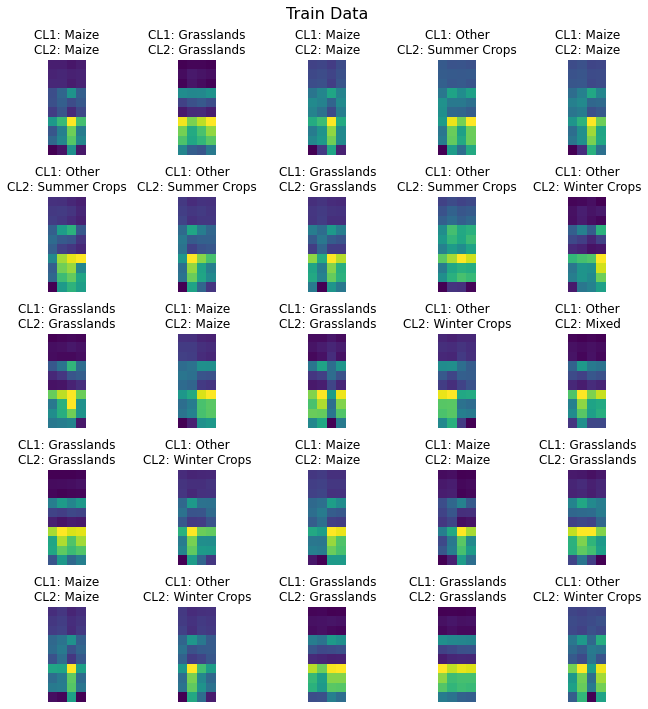

In [10]:
# Train data
visualize_batch(s_we_train_X_np, s_we_train_Y_np_cl1, s_we_train_Y_np_cl2, cl1_names, cl2_names, "Train Data")

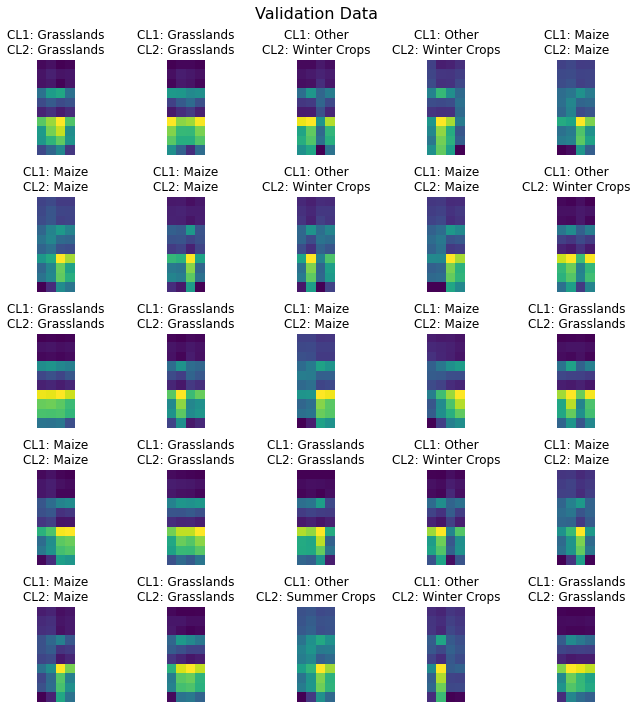

In [11]:
# Validation data
visualize_batch(s_we_val_X_np, s_we_val_Y_np_cl1, s_we_val_Y_np_cl2, cl1_names, cl2_names, "Validation Data")

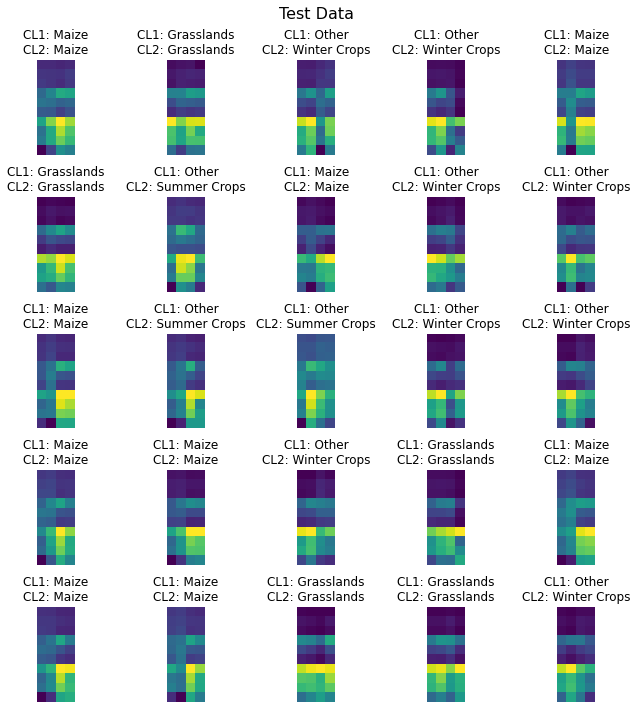

In [12]:
# Test data
visualize_batch(s_we_test_X_np, s_we_test_Y_np_cl1, s_we_test_Y_np_cl2, cl1_names, cl2_names, "Test Data")

## 3.0 Model definition

### 3.5 Define Random Forest Model

In [13]:
rf_model_cl1 = RandomForestClassifier(random_state = 22, 
                                      max_features='sqrt', 
                                      criterion='entropy', 
                                      min_samples_leaf=1, 
                                      min_samples_split=8, 
                                      n_estimators=600, 
                                      n_jobs=-1, verbose=True)

rf_model_cl2 = RandomForestClassifier(random_state = 22, 
                                      max_features='sqrt', 
                                      criterion='entropy', 
                                      min_samples_leaf=1, 
                                      min_samples_split=8, 
                                      n_estimators=600, 
                                      n_jobs=-1, verbose=True)

### 3.6 RF Model Training

#### 3.6.1 Training RF Model for CL1

In [14]:
rf_model_cl1.fit(X=s_we_train_X_df, y=s_we_train_Y_np_cl1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   39.6s finished


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=8, n_estimators=600, n_jobs=-1,
                       random_state=22, verbose=True)

In [15]:
import joblib

joblib.dump(rf_model_cl1, "./Out/RF_Models/rf_model_we_cl1_trained.joblib", compress=3)

['./Out/RF_Models/rf_model_we_cl1_trained.joblib']

#### 3.6.2 Training RF Model for CL2

In [16]:
rf_model_cl2.fit(X=s_we_train_X_df, y=s_we_train_Y_np_cl2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   50.4s finished


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_split=8, n_estimators=600, n_jobs=-1,
                       random_state=22, verbose=True)

In [17]:
joblib.dump(rf_model_cl2, "./Out/RF_Models/rf_model_we_cl2_trained.joblib", compress=3)

['./Out/RF_Models/rf_model_we_cl2_trained.joblib']

### 3.7 Normal CNN model define

In [18]:

def get_deterministic_seq_model(input_shape, loss, optimizer, metrics, ncls):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    model = Sequential([
        Conv2D(kernel_size=(3, 3), filters=16, activation='relu', padding='same', strides=(1, 1), input_shape=input_shape, name='b1_conv1'), 
        Conv2D(kernel_size=(3, 3), filters=32, activation='relu', padding='same', strides=(1, 1), name='b1_conv2'), 
        BatchNormalization(), 
        MaxPooling2D(pool_size=(1, 2),  name='b1_pool'), 
        
        Conv2D(kernel_size=(3, 3), filters=48, activation='relu', padding='same', strides=(1, 1), input_shape=input_shape, name='b2_conv1'), 
        Conv2D(kernel_size=(3, 3), filters=64, activation='relu', padding='same', strides=(1, 1), input_shape=input_shape, name='b2_conv2'), 
        BatchNormalization(), 
        MaxPooling2D(pool_size=(2, 2), padding='same',  name='b2_pool'),  
        
        Flatten(name='flatten'), 
        Dense(units=128, activation='relu', name='dense1'), 
        BatchNormalization(), 
        Dropout(0.25), 
        Dense(units=48, activation='relu', name='dense2'), 
        BatchNormalization(), 
        Dropout(0.25), 
        Dense(units=ncls, activation='softmax', name='predi')
    ])
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [19]:
def get_deterministic_model(input_shape, ncls):
    """
    This function should build and compile a CNN model according to the above specification. 
    The function takes input_shape, loss, optimizer and metrics as arguments, which should be
    used to define and compile the model.
    Your function should return the compiled model.
    """
    # Model Input
    model_input = Input(shape=input_shape, name='image_input')
    
    # 1st conv block
    model = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', name='b1_conv1')(model_input)
    model = BatchNormalization()(model)
    model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', name='b1_conv2')(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D(pool_size=(1, 2), name='b1_pool')(model)
    
    # 2nd conv block
    model = Conv2D(filters=48, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', name='b2_conv1')(model)
    model = BatchNormalization()(model)
    model = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='same', name='b2_conv2')(model)
    model = BatchNormalization()(model)
    model = MaxPooling2D(pool_size=(2, 2), name='b2_pool')(model)
    
    # ANN block (CL2)
    model = Flatten(name='flatten')(model)
    model = Dense(units=128, activation='relu', name='dense1')(model)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    model = Dense(units=64, activation='relu', name='dense2')(model)
    model = BatchNormalization()(model)
    model = Dropout(0.25)(model)
    
    # Output layer
    cl_pred = Dense(units=ncls, activation='softmax', name='predi')(model)
    
    outmodel = Model(inputs=model_input, outputs=cl_pred)
    
    
    # model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return outmodel


### 3.8 Create CNN models

In [20]:
# CNN model for CL1

# tf.random.set_seed(22)
# dcnn_model_cl1 = get_deterministic_model(
    # input_shape=(10, 4, 1),  
    # loss=CategoricalCrossentropy(), 
    # optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
    # metrics=['accuracy'], 
    # ncls=3
# )
# dcnn_model_cl1.summary()

In [21]:
# CNN model for CL1

tf.random.set_seed(22)
dcnn_model_cl1 = get_deterministic_model(
    input_shape=(10, 4, 1), 
    ncls=3)

dcnn_model_cl1.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
                       loss=CategoricalCrossentropy(), 
                       metrics=['accuracy'])
dcnn_model_cl1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 10, 4, 1)]        0         
                                                                 
 b1_conv1 (Conv2D)           (None, 10, 4, 16)         160       
                                                                 
 batch_normalization (BatchN  (None, 10, 4, 16)        64        
 ormalization)                                                   
                                                                 
 b1_conv2 (Conv2D)           (None, 10, 4, 32)         4640      
                                                                 
 batch_normalization_1 (Batc  (None, 10, 4, 32)        128       
 hNormalization)                                                 
                                                                 
 b1_pool (MaxPooling2D)      (None, 10, 2, 32)         0     

2023-01-06 17:51:39.480568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 17:51:39.480981: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 17:51:39.486319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 17:51:39.486712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 17:51:39.487087: I tensorflow/compiler/xla/stream_executo

In [22]:
# CNN model for CL2

tf.random.set_seed(22)
dcnn_model_cl2 = get_deterministic_model(
    input_shape=(10, 4, 1), 
    ncls=5)

dcnn_model_cl2.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), 
                       loss=CategoricalCrossentropy(), 
                       metrics=['accuracy'])
dcnn_model_cl2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 10, 4, 1)]        0         
                                                                 
 b1_conv1 (Conv2D)           (None, 10, 4, 16)         160       
                                                                 
 batch_normalization_6 (Batc  (None, 10, 4, 16)        64        
 hNormalization)                                                 
                                                                 
 b1_conv2 (Conv2D)           (None, 10, 4, 32)         4640      
                                                                 
 batch_normalization_7 (Batc  (None, 10, 4, 32)        128       
 hNormalization)                                                 
                                                                 
 b1_pool (MaxPooling2D)      (None, 10, 2, 32)         0   

### 3.9 CNN Model Training

#### 3.9.1 Training CNN Model for CL1

In [23]:
start = datetime.now()
history_dcnn_model_cl1 = dcnn_model_cl1.fit(
    s_we_train_X_np, tf.keras.utils.to_categorical(s_we_train_Y_np_cl1, 3), 
    batch_size=200, epochs=50, verbose=2, 
    validation_data=(s_we_val_X_np, tf.keras.utils.to_categorical(s_we_val_Y_np_cl1, 3))
)
end = datetime.now()
td = (end - start).total_seconds() /60 #* 10**3
print(f"The time of execution of CNN CL1 model training is : {td:.02f}minutes")

Epoch 1/50


2023-01-06 17:51:42.217257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-06 17:51:43.112542: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb3b1fcadc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-06 17:51:43.112561: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-01-06 17:51:43.112565: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-01-06 17:51:43.159282: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 - 17s - loss: 0.6683 - accuracy: 0.7519 - val_loss: 2.7526 - val_accuracy: 0.2261 - 17s/epoch - 45ms/step
Epoch 2/50
375/375 - 15s - loss: 0.5198 - accuracy: 0.8180 - val_loss: 0.2818 - val_accuracy: 0.9026 - 15s/epoch - 39ms/step
Epoch 3/50
375/375 - 14s - loss: 0.4758 - accuracy: 0.8358 - val_loss: 0.2331 - val_accuracy: 0.9194 - 14s/epoch - 37ms/step
Epoch 4/50
375/375 - 15s - loss: 0.4515 - accuracy: 0.8435 - val_loss: 0.2253 - val_accuracy: 0.9243 - 15s/epoch - 39ms/step
Epoch 5/50
375/375 - 13s - loss: 0.4295 - accuracy: 0.8501 - val_loss: 0.2283 - val_accuracy: 0.9204 - 13s/epoch - 35ms/step
Epoch 6/50
375/375 - 15s - loss: 0.4183 - accuracy: 0.8552 - val_loss: 0.2298 - val_accuracy: 0.9189 - 15s/epoch - 40ms/step
Epoch 7/50
375/375 - 14s - loss: 0.4053 - accuracy: 0.8586 - val_loss: 0.2133 - val_accuracy: 0.9254 - 14s/epoch - 37ms/step
Epoch 8/50
375/375 - 15s - loss: 0.3988 - accuracy: 0.8601 - val_loss: 0.2609 - val_accuracy: 0.9015 - 15s/epoch - 40ms/step
Epoch 9/50


In [24]:
dcnn_model_cl1.save('./Out/CNN_Models/dcnn_model_we_cl1_trained.hdf5')

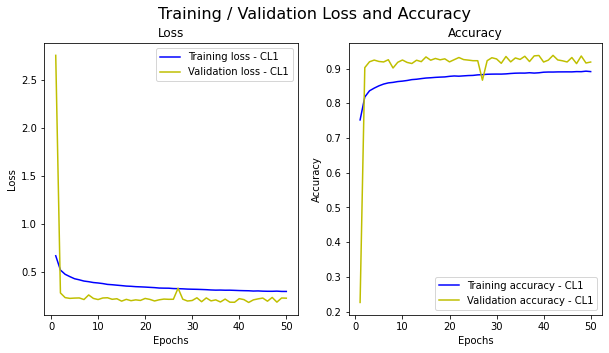

In [25]:
# plot the training and validation accuracy and loss at each epoch
loss_cl1 = history_dcnn_model_cl1.history['loss']
val_loss_cl1 = history_dcnn_model_cl1.history['val_loss']
acc_cl1 = history_dcnn_model_cl1.history['accuracy']
val_acc_cl1 = history_dcnn_model_cl1.history['val_accuracy']

epochs = range(1, 50 + 1)

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Training / Validation Loss and Accuracy', fontsize=16)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(epochs, loss_cl1, 'b', label='Training loss - CL1')
plt.plot(epochs, val_loss_cl1, 'y', label='Validation loss - CL1')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_cl1, 'b', label='Training accuracy - CL1')
plt.plot(epochs, val_acc_cl1, 'y', label='Validation accuracy - CL1')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### 3.9.2 Training CNN Model for CL2

In [26]:
start = datetime.now()
history_dcnn_model_cl2 = dcnn_model_cl2.fit(
    s_we_train_X_np, tf.keras.utils.to_categorical(s_we_train_Y_np_cl2, 5), 
    batch_size=200, epochs=50, verbose=1, 
    validation_data=(s_we_val_X_np, tf.keras.utils.to_categorical(s_we_val_Y_np_cl2, 5))
)
end = datetime.now()
td = (end - start).total_seconds() /60 #* 10**3
print(f"The time of execution of CNN CL2 model training is : {td:.02f}minutes")

Epoch 1/50
375/375 [==============================] - 16s 39ms/step - loss: 0.9835 - accuracy: 0.6639 - val_loss: 2.1059 - val_accuracy: 0.1092
Epoch 2/50
375/375 [==============================] - 14s 37ms/step - loss: 0.7692 - accuracy: 0.7398 - val_loss: 0.4648 - val_accuracy: 0.8465
Epoch 3/50
375/375 [==============================] - 15s 39ms/step - loss: 0.7241 - accuracy: 0.7559 - val_loss: 0.3316 - val_accuracy: 0.8934
Epoch 4/50
375/375 [==============================] - 14s 39ms/step - loss: 0.6980 - accuracy: 0.7649 - val_loss: 0.3232 - val_accuracy: 0.8956
Epoch 5/50
375/375 [==============================] - 14s 39ms/step - loss: 0.6744 - accuracy: 0.7731 - val_loss: 0.3420 - val_accuracy: 0.8889
Epoch 6/50
375/375 [==============================] - 13s 36ms/step - loss: 0.6562 - accuracy: 0.7783 - val_loss: 0.3532 - val_accuracy: 0.8824
Epoch 7/50
375/375 [==============================] - 14s 37ms/step - loss: 0.6417 - accuracy: 0.7828 - val_loss: 0.3111 - val_accuracy:

In [27]:
dcnn_model_cl2.save('./Out/CNN_Models/dcnn_model_we_cl2_trained.hdf5')

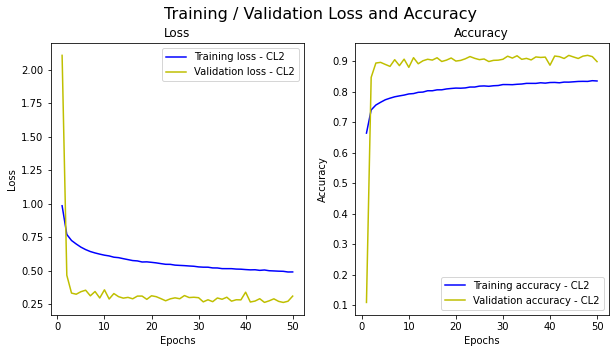

In [28]:
# plot the training and validation accuracy and loss at each epoch
loss_cl2 = history_dcnn_model_cl2.history['loss']
val_loss_cl2 = history_dcnn_model_cl2.history['val_loss']
acc_cl2 = history_dcnn_model_cl2.history['accuracy']
val_acc_cl2 = history_dcnn_model_cl2.history['val_accuracy']

epochs = range(1, 50 + 1)

fig = plt.figure(figsize=(10, 5))
fig.suptitle('Training / Validation Loss and Accuracy', fontsize=16)

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(epochs, loss_cl2, 'b', label='Training loss - CL2')
plt.plot(epochs, val_loss_cl2, 'y', label='Validation loss - CL2')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_cl2, 'b', label='Training accuracy - CL2')
plt.plot(epochs, val_acc_cl2, 'y', label='Validation accuracy - CL2')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 4.0 Model Testing/Evaluation (AKA - Reference Accuracy)

### 4.1 CL1 models

#### 4.1.2 RF-CL1

In [29]:
# Check reference system accuracy

rf_model_cl1_pred_hot  = rf_model_cl1.predict(s_we_test_X_df)
# Convert predictions classes to one hot vectors 
rf_model_cl1_pred = rf_model_cl1_pred_hot # np.argmax(rf_model_cl1_pred_hot, axis = 1) 
# Convert test data to one hot vectors
rf_model_cl1_true = s_we_test_Y_np_cl1

# CM
rf_model_cl1_cm = confusion_matrix(rf_model_cl1_true, rf_model_cl1_pred)

# Accuracy
rf_model_cl1_acc = accuracy_score(y_true=rf_model_cl1_true, y_pred=rf_model_cl1_pred, normalize=True)

# Macro F1
rf_model_cl1_macroF1 = f1_score(y_true=rf_model_cl1_true, y_pred=rf_model_cl1_pred, average='macro')

print("=================================\n")
print('RF NH Model CL1 Validation')
print(rf_model_cl1_cm)
print("Validation accuracy for RF NH model for CL1: " + str(round(rf_model_cl1_acc, 3)))
print("Validation MacroF1 for RF NH model for CL1: " + str(round(rf_model_cl1_macroF1, 3)))
print("=================================\n")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s



RF NH Model CL1 Validation
[[7678   78  300]
 [1468 8060  191]
 [ 386   22 3851]]
Validation accuracy for RF NH model for CL1: 0.889
Validation MacroF1 for RF NH model for CL1: 0.89



[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.3s finished


In [30]:
rf_model_cl1_clsF1 = f1_score(y_true=rf_model_cl1_true, y_pred=rf_model_cl1_pred, average=None)

rf_cl1_f1 = [list(cl1_names.values()), rf_model_cl1_clsF1.tolist()]
rf_cl1_f1_df = pd.DataFrame(rf_cl1_f1)
rf_cl1_f1_df = rf_cl1_f1_df.transpose()
 
# specifying column names
rf_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('RF NH Model CL1 Test')
rf_cl1_f1_df



RF NH Model CL1 Test


,Class,F1
0,Other,0.873095
1,Maize,0.901616
2,Grasslands,0.895477


#### 4.1.3 CNN-CL1

In [31]:
# Check reference system accuracy

dcnn_model_cl1_pred_hot  = dcnn_model_cl1.predict(s_we_test_X_np)
# Convert predictions classes to one hot vectors 
dcnn_model_cl1_pred = np.argmax(dcnn_model_cl1_pred_hot, axis = 1) 
# Convert test data to one hot vectors
dcnn_model_cl1_true = s_we_test_Y_np_cl1

# CM
dcnn_model_cl1_cm = confusion_matrix(dcnn_model_cl1_true, dcnn_model_cl1_pred)

# Accuracy
dcnn_model_cl1_acc = accuracy_score(y_true=dcnn_model_cl1_true, y_pred=dcnn_model_cl1_pred, normalize=True)

# Macro F1
dcnn_model_cl1_macroF1 = f1_score(y_true=dcnn_model_cl1_true, y_pred=dcnn_model_cl1_pred, average='macro')

print("=================================\n")
print('CNN NH Model CL1 Validation')
print(dcnn_model_cl1_cm)
print("Validation accuracy for CNN NH model for CL1: " + str(round(dcnn_model_cl1_acc, 3)))
print("Validation MacroF1 for CNN NH model for CL1: " + str(round(dcnn_model_cl1_macroF1, 3)))
print("=================================\n")

689/689 [==============================] - 1s 1ms/step

CNN NH Model CL1 Validation
[[7861   65  130]
 [1464 8140  115]
 [ 426   14 3819]]
Validation accuracy for CNN NH model for CL1: 0.9
Validation MacroF1 for CNN NH model for CL1: 0.903



In [32]:
dcnn_model_cl1_clsF1 = f1_score(y_true=dcnn_model_cl1_true, y_pred=dcnn_model_cl1_pred, average=None)

dcnn_cl1_f1 = [list(cl1_names.values()), dcnn_model_cl1_clsF1.tolist()]
dcnn_cl1_f1_df = pd.DataFrame(dcnn_cl1_f1)
dcnn_cl1_f1_df = dcnn_cl1_f1_df.transpose()
 
# specifying column names
dcnn_cl1_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('CNN NH Model CL1 Test')
dcnn_cl1_f1_df



CNN NH Model CL1 Test


,Class,F1
0,Other,0.882911
1,Maize,0.907571
2,Grasslands,0.917698


### 4.2 CL2 models

#### 4.2.2 RF-CL2

In [33]:
# Check reference system accuracy

rf_model_cl2_pred_hot  = rf_model_cl2.predict(s_we_test_X_df)
# Convert predictions classes to one hot vectors 
rf_model_cl2_pred = rf_model_cl2_pred_hot #np.argmax(rf_model_cl2_pred_hot, axis = 1) 
# Convert test data to one hot vectors
rf_model_cl2_true = s_we_test_Y_np_cl2

# CM
rf_model_cl2_cm = confusion_matrix(rf_model_cl2_true, rf_model_cl2_pred)

# Accuracy
rf_model_cl2_acc = accuracy_score(y_true=rf_model_cl2_true, y_pred=rf_model_cl2_pred, normalize=True)

# Macro F1
rf_model_cl2_macroF1 = f1_score(y_true=rf_model_cl2_true, y_pred=rf_model_cl2_pred, average='macro')

print("=================================\n")
print('RF NH Model CL2 Validation')
print(rf_model_cl2_cm)
print("Validation accuracy for RF NH model for CL2: " + str(round(rf_model_cl2_acc, 3)))
print("Validation MacroF1 for RF NH model for CL2: " + str(round(rf_model_cl2_macroF1, 3)))
print("=================================\n")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s



RF NH Model CL2 Validation
[[ 126   22   60   32    6]
 [ 304 8482  268  646   19]
 [ 238   29 3949   29   14]
 [ 196   72   61 1038   71]
 [ 118   21  328   43 5862]]
Validation accuracy for RF NH model for CL2: 0.883
Validation MacroF1 for RF NH model for CL2: 0.722



[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 600 out of 600 | elapsed:    0.4s finished


In [34]:
rf_model_cl2_clsF1 = f1_score(y_true=rf_model_cl2_true, y_pred=rf_model_cl2_pred, average=None)

rf_cl2_f1 = [list(cl2_names.values()), rf_model_cl2_clsF1.tolist()]
rf_cl2_f1_df = pd.DataFrame(rf_cl2_f1)
rf_cl2_f1_df = rf_cl2_f1_df.transpose()
 
# specifying column names
rf_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('RF NH Model CL2 Test')
rf_cl2_f1_df


RF NH Model CL2 Test


,Class,F1
0,Mixed,0.205212
1,Maize,0.924721
2,Grasslands,0.88493
3,Summer Crops,0.643521
4,Winter Crops,0.949773


#### 4.2.3 CNN-CL2

In [35]:
# Check reference system accuracy

dcnn_model_cl2_pred_hot  = dcnn_model_cl2.predict(s_we_test_X_np)
# Convert predictions classes to one hot vectors 
dcnn_model_cl2_pred = np.argmax(dcnn_model_cl2_pred_hot, axis = 1) 
# Convert test data to one hot vectors
dcnn_model_cl2_true = s_we_test_Y_np_cl2

# CM
dcnn_model_cl2_cm = confusion_matrix(dcnn_model_cl2_true, dcnn_model_cl2_pred)

# Accuracy
dcnn_model_cl2_acc = accuracy_score(y_true=dcnn_model_cl2_true, y_pred=dcnn_model_cl2_pred, normalize=True)

# Macro F1
dcnn_model_cl2_macroF1 = f1_score(y_true=dcnn_model_cl2_true, y_pred=dcnn_model_cl2_pred, average='macro')

print("=================================\n")
print('CNN NH Model CL2 Validation')
print(dcnn_model_cl2_cm)
print("Validation accuracy for CNN NH model for CL2: " + str(round(dcnn_model_cl2_acc, 3)))
print("Validation MacroF1 for CNN NH model for CL2: " + str(round(dcnn_model_cl2_macroF1, 3)))
print("=================================\n")

689/689 [==============================] - 1s 1ms/step

CNN NH Model CL2 Validation
[[ 146   26   29   38    7]
 [ 236 8785   58  606   34]
 [ 491   29 3653   46   40]
 [ 167   68   25 1103   75]
 [  66   23   48   79 6156]]
Validation accuracy for CNN NH model for CL2: 0.901
Validation MacroF1 for CNN NH model for CL2: 0.74



In [36]:
dcnn_model_cl2_clsF1 = f1_score(y_true=dcnn_model_cl2_true, y_pred=dcnn_model_cl2_pred, average=None)

dcnn_cl2_f1 = [list(cl2_names.values()), dcnn_model_cl2_clsF1.tolist()]
dcnn_cl2_f1_df = pd.DataFrame(dcnn_cl2_f1)
dcnn_cl2_f1_df = dcnn_cl2_f1_df.transpose()
 
# specifying column names
dcnn_cl2_f1_df.columns = ['Class', 'F1']

print("=================================\n")
print('CNN NH Model CL2 Test')
dcnn_cl2_f1_df


CNN NH Model CL2 Test


,Class,F1
0,Mixed,0.215976
1,Maize,0.942091
2,Grasslands,0.905104
3,Summer Crops,0.666465
4,Winter Crops,0.970672


### 5.2 CNN model

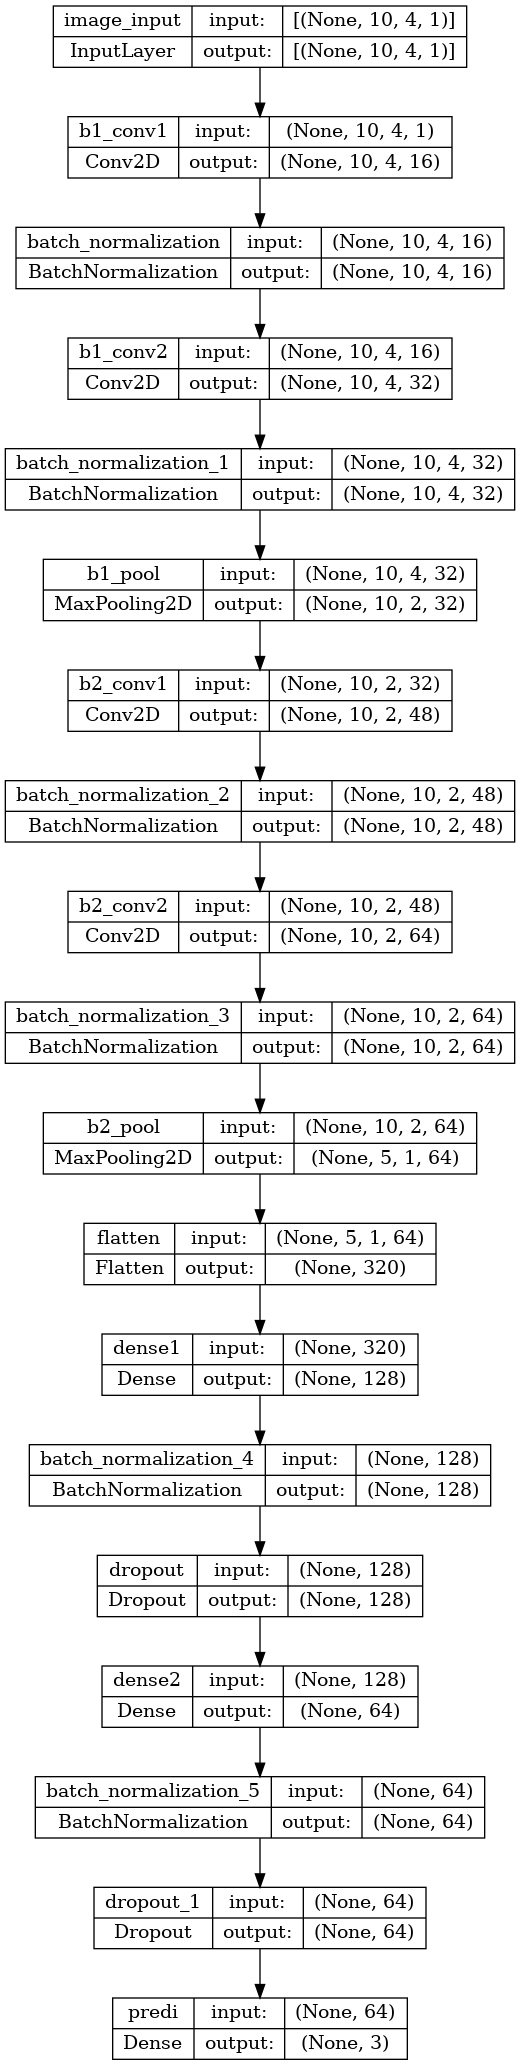

In [37]:
tf.keras.utils.plot_model(dcnn_model_cl1, show_shapes=True, rankdir="TB")

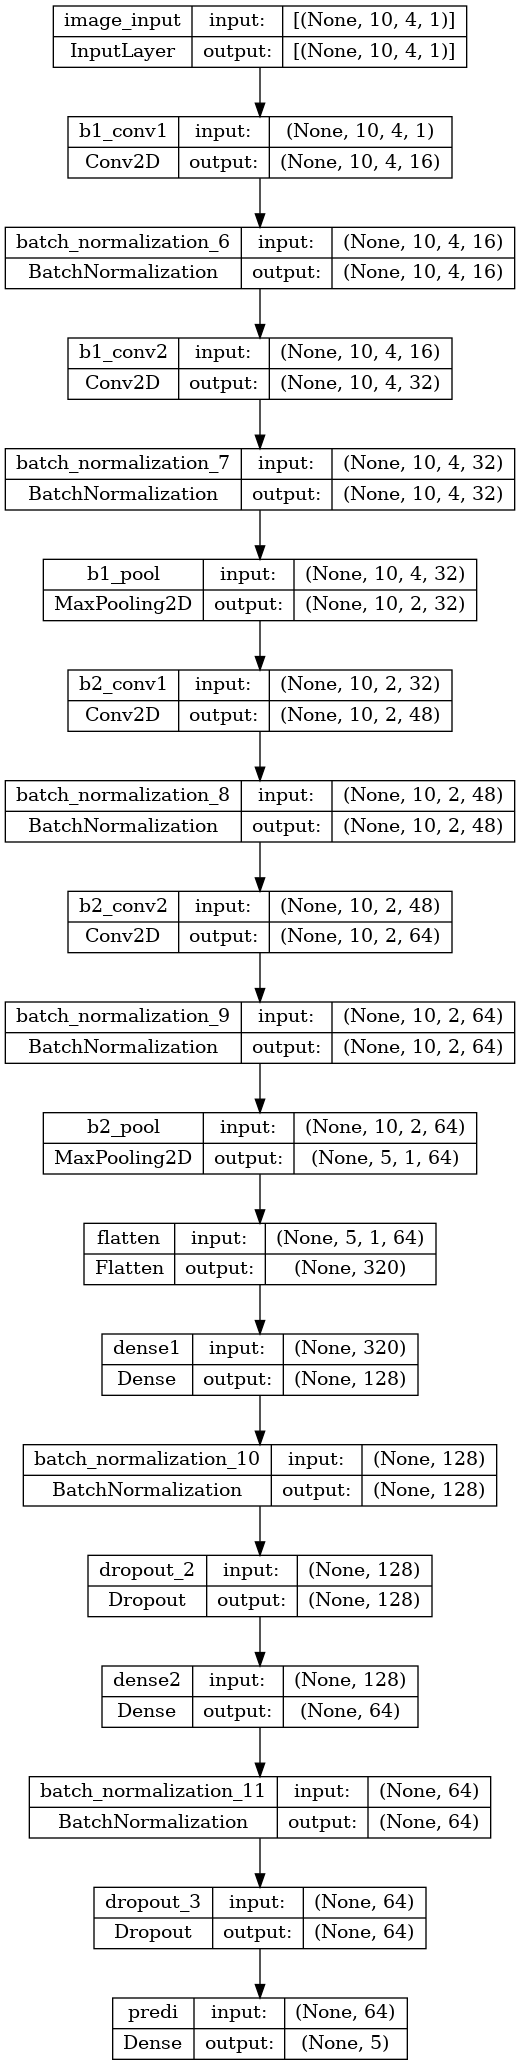

In [38]:
tf.keras.utils.plot_model(dcnn_model_cl2, show_shapes=True, rankdir="TB")